In [1]:
# %load_ext autoreload
# %autoreload 2    # tester cette magic function pdt le projet

# %autoreload 0

# Mise en place du notebook

## Import des modules

In [1]:
# pour développement
from pympler import asizeof
import mesfonctions_P7
from importlib import reload
mesfonctions_P7 = reload(mesfonctions_P7)

In [2]:
# from IPython.core.display import HTML
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from mesfonctions_P7 import display_scree_plot
from mesfonctions_P7 import display_circles
from mesfonctions_P7 import display_factorial_planes
import pickle
from termcolor import colored, cprint
import re
import imblearn
from collections import Counter

In [3]:
# Où suis-je ?
import os
dirpath = os.getcwd()
print("Working directory is : " + dirpath)

Working directory is : C:\Users\jmjoe\home-credit-default-risk


In [4]:
# List files available
inputpath = dirpath + "/input/"
print(os.listdir(inputpath))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


## Gestion des paramètres d'affichage de Jupyter

In [26]:
plt.style.use('seaborn')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:95% }</style>")

## Constantes

## Fonctions courantes

In [6]:
def EDA(df, samples=10000):
    """Réalise l'analyse exploratoire avec dataprep.
    Args :
    - df : dataframe pandas
    - samples : nb de lignes du df inclues dans l'analyse (si samples=None : on garde le df entier).
    Returns :
    - void (le rapport d'analyse est sauvé dans un fichier pickle et affiché dans une nouvelle fenêtre du web-browser)
    """
    from dataprep.eda import create_report
    import os
    
    def print_var_name(variable):
        """Convertit un nom de variable en string"""
        for name in globals():
            if eval(name) is variable and name not in ['_', '__', '___']:
                return name
    
    # sampling
    samples = samples if len(df) > samples else None
    text_samples = "max" if samples is None else str(samples)
    df_sampled = df.sample(samples, random_state=0)
    
    # un pickle est chargé si le rapport existe déjà sinon un rapport est créé
    nom_rapport = print_var_name(df) + " - EDA pour Projet 7 - " + text_samples + " samples" 
    try:
        rapport = pickle.load(open(nom_rapport + ".pkl", 'rb'))
        print("Chargement du fichier : " + nom_rapport + ".pkl")
    except FileNotFoundError:
        print("Calcul du rapport... ", end='')
        rapport = create_report(df_sampled, title=nom_rapport, config={"insight.skewed.threshold": 0})
        print("Calcul terminé. Sauvegarde sous forme de pickle.")
        pickle.dump(rapport, open(nom_rapport + ".pkl", 'wb'))
    
    # Affichage du rapport dans une nouvelle fenêtre
    print(f"Taille du fichier : {round(os.path.getsize(nom_rapport + '.pkl')/1024/1024)} MB")
    print("Ouverture du rapport dans une nouvelle fenêtre")
    rapport.show_browser()

In [7]:
def affichage_scores(grid_search, tri=False) : 
    """Retourne les scores pour les différentes valeurs testées de GridSearch ou GridSearchCV.
    Args :
    - grid_search : instance de  GridSearch après cross-validation.
    - tri : booléen pour effectuer un tri des scores.
    Returns : 
    - print des scores et des paramètres de grid_search correspondant.
    """
    score_name = grid_search.scoring
    cvres = grid_search.cv_results_
    
    # Traitement des résultats
    dummy_list = [x for x in range(len(cvres["mean_test_score"]))]    # on est obligés de rajouter cette valeur dummy pour que la méthode sort() ne plante pas car en cas d'égalité de score elle va chercher à comparer des dictionnaires (cvres["params"])
    resultats_zip = zip(cvres["mean_test_score"], dummy_list, cvres["params"])
    resultats_zip = list(resultats_zip)
    if tri:
        resultats_zip.sort(reverse=True)   # tri par score décroissant
        
    # Impression
    for mean_score, _, params in resultats_zip:
        print(score_name, "=", ("%.3f" % mean_score).ljust(8, ' '), params)
    if not tri:
        print("Best", score_name, "=", ("%.3f" % grid_search.best_score_).ljust(8, ' '), grid_search.best_params_)
    
    


In [8]:
def metriques_classif_binaire(clf, X_validation, y_validation, titre="Courbe ROC du classifieur sur le jeu de validation"):
    y_split_valid_pred = clf.predict(X_validation)
    y_split_valid_pred_proba = clf.predict_proba(X_validation)

    # Matrice de confusion
    display(pd.DataFrame(confusion_matrix(y_validation, y_split_valid_pred), columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

    fpr, tpr, thr = roc_curve(y_validation, y_split_valid_pred_proba[:,1])

    # get the best threshold (Youden's J Statistic)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thr = thr[ix]

    # Tracé de la courbe ROC
    plt.figure(edgecolor='black', linewidth=4)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = %0.4f)" % auc(fpr, tpr)
    )
    plt.plot(
        fpr,
        tpr-fpr,
        color="darkgreen",
        lw=2,
        label="Youden J Statistic (best threshold = %0.4f)" % best_thr
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title(titre, fontsize=14)
    plt.legend(loc="upper left", fontsize=12)
    plt.show()
    
    # Tracé de l'histogramme des predict_proba
    plt.figure(edgecolor='black', linewidth=4)
    plt.hist(y_split_valid_pred_proba[:,1], bins=100)
    plt.xlim([-0.01, 1.01])
    plt.xlabel("predict_proba", size=12)
    plt.ylabel("Count", size=12)
    plt.title("Histogramme des predict_proba", fontsize=14)
    plt.show()


# Notes

Lien vers l'énoncé OC : https://openclassrooms.com/fr/paths/164/projects/632/assignment  
  
Lien vers l'énoncé Kaggle : https://www.kaggle.com/c/home-credit-default-risk/overview  

Lien direct pour télécharger les data : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip  

Lien vers une prise en main rapide de la data :
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

Mes soumissions à Kaggle : https://www.kaggle.com/c/home-credit-default-risk/submit

# Récupération des données et analyse par dataprep

## df_description

In [19]:
df_description = pd.read_csv('input/HomeCredit_columns_description.csv',
                           sep=',',
                           low_memory=False, encoding='ISO-8859-1')

In [20]:
len(df_description)

219

In [21]:
display(df_description)

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [25]:
HTML(df_description.to_html())

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [14]:
# Imprime les lignes du dataframe df_description avec un formatage amélioré   # à supprimer, car " HTML(df_description.to_html()) " fait plus joli
print(colored("TABLE".ljust(28, ' '), 'blue', attrs=['bold']), end="  ")
print(colored("ROW".ljust(28, ' '), 'magenta', attrs=['bold']), end="  ")
print(colored("SPECIAL".ljust(15, ' '), 'blue', attrs=['bold']), end="  ")
print(colored("DESCRIPTION", attrs=['bold']))
previous_table=""
for i in range(len(df_description)):
    current_table = df_description['Table'][i]
    if current_table == previous_table:
        print("".ljust(28, ' '), end="  ")
    else:    
        print(colored(current_table.ljust(28, ' '), 'blue', attrs=['bold']), end="  ")
    previous_table = current_table
    print(colored(df_description['Row'][i].ljust(28, ' '), 'magenta', attrs=['bold']), end="  ")
    print(colored(str(df_description['Special'][i]).ljust(15, ' '), 'blue', attrs=['bold']), end="  ")## df_description
    print(df_description['Description'][i])

TABLE                         ROW                           SPECIAL          DESCRIPTION
application_{train|test}.csv  SK_ID_CURR                    nan              ID of loan in our sample
                              TARGET                        nan              Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
                              NAME_CONTRACT_TYPE            nan              Identification if loan is cash or revolving
                              CODE_GENDER                   nan              Gender of the client
                              FLAG_OWN_CAR                  nan              Flag if the client owns a car
                              FLAG_OWN_REALTY               nan              Flag if client owns a house or flat
                              CNT_CHILDREN                  nan              Number of children the clien

## df_application_train

In [8]:
df_application_train= pd.read_csv('input/application_train.csv',
                           sep=',',
                           low_memory=False)

In [9]:
df_application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [13]:
EDA(df_application_train)

NumExpr defaulting to 8 threads.


Chargement du fichier : df_application_train - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 124 MB
Ouverture du rapport dans une nouvelle fenêtre


In [14]:
df_application_train[df_application_train['SK_ID_CURR'] == 100002]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## df_application_test

In [15]:
df_application_test = pd.read_csv('input/application_test.csv',
                           sep=',',
                           low_memory=False)

In [16]:
df_application_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Marr

In [17]:
EDA(df_application_test)

Chargement du fichier : df_application_test - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 124 MB
Ouverture du rapport dans une nouvelle fenêtre


## df_bureau

In [68]:
df_bureau = pd.read_csv('input/bureau.csv',
                           sep=',',
                           low_memory=False)

In [19]:
df_bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [20]:
EDA(df_bureau)

Chargement du fichier : df_bureau - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 10 MB
Ouverture du rapport dans une nouvelle fenêtre


In [21]:
df_bureau[df_bureau['SK_ID_CURR'] == 100002]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
675684,100002,6158904,Closed,currency 1,-1125,0,-1038.0,-1038.0,NaN,0,40761.000,NaN,NaN,0.0,Credit card,-1038,0.0
675685,100002,6158905,Closed,currency 1,-476,0,NaN,-48.0,NaN,0,0.000,0.0,NaN,0.0,Credit card,-47,NaN
675686,100002,6158906,Closed,currency 1,-1437,0,-1072.0,-1185.0,0.000,0,135000.000,0.0,0.000,0.0,Consumer credit,-1185,0.0
675687,100002,6158907,Closed,currency 1,-1121,0,-911.0,-911.0,3321.000,0,19071.000,NaN,NaN,0.0,Consumer credit,-906,0.0
675688,100002,6158908,Closed,currency 1,-645,0,85.0,-36.0,5043.645,0,120735.000,0.0,0.000,0.0,Consumer credit,-34,0.0
675689,100002,6158909,Active,currency 1,-103,0,NaN,NaN,40.500,0,31988.565,0.0,31988.565,0.0,Credit card,-24,0.0
1337779,100002,6158903,Active,currency 1,-1042,0,780.0,NaN,NaN,0,450000.000,245781.0,0.000,0.0,Consumer credit,-7,0.0
1486113,100002,6113835,Closed,currency 1,-1043,0,62.0,-967.0,0.000,0,67500.000,NaN,NaN,0.0,Credit card,-758,0.0


## df_bureau_balance

In [22]:
df_bureau_balance = pd.read_csv('input/bureau_balance.csv',
                           sep=',',
                           low_memory=False)

In [23]:
df_bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [24]:
EDA(df_bureau_balance)

Chargement du fichier : df_bureau_balance - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 3 MB
Ouverture du rapport dans une nouvelle fenêtre


In [25]:
df_bureau_balance[df_bureau_balance['SK_ID_BUREAU'] == 6158904]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
13472782,6158904,-15,C
13472783,6158904,-16,C
13472784,6158904,-17,0
13472785,6158904,-18,0
13472786,6158904,-19,0
13472787,6158904,-20,1
13472788,6158904,-21,0
13472789,6158904,-22,0
13472790,6158904,-23,0
13472791,6158904,-24,0


## df_POS_CASH_balance

In [26]:
df_POS_CASH_balance = pd.read_csv('input/POS_CASH_balance.csv',
                           sep=',',
                           low_memory=False)

In [27]:
df_POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [28]:
EDA(df_POS_CASH_balance)

Chargement du fichier : df_POS_CASH_balance - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 4 MB
Ouverture du rapport dans une nouvelle fenêtre


In [29]:
df_POS_CASH_balance[df_POS_CASH_balance['SK_ID_CURR'] == 100002].sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
8473918,1038818,100002,-19,24.0,24.0,Active,0,0
2012884,1038818,100002,-18,24.0,23.0,Active,0,0
5258607,1038818,100002,-17,24.0,22.0,Active,0,0
1216849,1038818,100002,-16,24.0,21.0,Active,0,0
9849444,1038818,100002,-15,24.0,20.0,Active,0,0
7403606,1038818,100002,-14,24.0,19.0,Active,0,0
513222,1038818,100002,-13,24.0,18.0,Active,0,0
9228061,1038818,100002,-12,24.0,17.0,Active,0,0
8701895,1038818,100002,-11,24.0,16.0,Active,0,0
7601963,1038818,100002,-10,24.0,15.0,Active,0,0


## df_credit_card_balance

In [30]:
df_credit_card_balance = pd.read_csv('input/credit_card_balance.csv',
                           sep=',',
                           low_memory=False)

In [31]:
df_credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.00,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.00,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.00,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.00,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.00,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,1879.11,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,375750.00,356994.675,269356.140,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [32]:
EDA(df_credit_card_balance)

Chargement du fichier : df_credit_card_balance - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 9 MB
Ouverture du rapport dans une nouvelle fenêtre


## df_previous_application

In [33]:
df_previous_application = pd.read_csv('input/previous_application.csv',
                           sep=',',
                           low_memory=False)

In [34]:
df_previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP,NaN,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [35]:
EDA(df_previous_application)

Chargement du fichier : df_previous_application - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 40 MB
Ouverture du rapport dans une nouvelle fenêtre


In [36]:
df_previous_application[df_previous_application['SK_ID_CURR'] == 100002]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,Y,1,0.0,NaN,NaN,XAP,Approved,-606,XNA,XAP,NaN,New,Vehicles,POS,XNA,Stone,500,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0


## df_installments_payments

In [37]:
df_installments_payments = pd.read_csv('input/installments_payments.csv',
                           sep=',',
                           low_memory=False)

In [38]:
df_installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [39]:
EDA(df_installments_payments)

Chargement du fichier : df_installments_payments - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 2 MB
Ouverture du rapport dans une nouvelle fenêtre


In [40]:
df_installments_payments[df_installments_payments['SK_ID_CURR'] == 100002].sort_values('NUM_INSTALMENT_NUMBER')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
2144879,1038818,100002,1.0,1,-565.0,-587.0,9251.775,9251.775
2163032,1038818,100002,1.0,2,-535.0,-562.0,9251.775,9251.775
1675768,1038818,100002,1.0,3,-505.0,-529.0,9251.775,9251.775
3343696,1038818,100002,1.0,4,-475.0,-498.0,9251.775,9251.775
2841063,1038818,100002,1.0,5,-445.0,-468.0,9251.775,9251.775
1807424,1038818,100002,1.0,6,-415.0,-446.0,9251.775,9251.775
3594829,1038818,100002,1.0,7,-385.0,-412.0,9251.775,9251.775
210205,1038818,100002,1.0,8,-355.0,-375.0,9251.775,9251.775
607863,1038818,100002,1.0,9,-325.0,-344.0,9251.775,9251.775
2646927,1038818,100002,1.0,10,-295.0,-312.0,9251.775,9251.775


# Nettoyage

DAYS_EMPLOYED : supprimer les nombreuses lignes à +365K  
OWN_CAR_AGE : mettre age max à 60  
Attention aux triplettes de variables : _AVG _MEDI _MODE.  1) je n'ai pas compris ce que c'est    2) elles sont souvent très corrélées.

# Feature engineering

# Analyse exploratoire

# Kernels de WILL KOEHRSEN

## Kernel 1 : A Gentle Introduction

https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

In [59]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
# Training data
app_train = pd.read_csv('input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Testing data features
app_test = pd.read_csv('input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [5]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [6]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [7]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


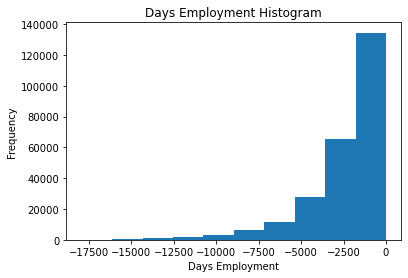

In [9]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [48]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [26]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))b

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [30]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
print(app_train['DAYS_BIRTH'].corr(app_train['TARGET']))

-0.07823930830982712


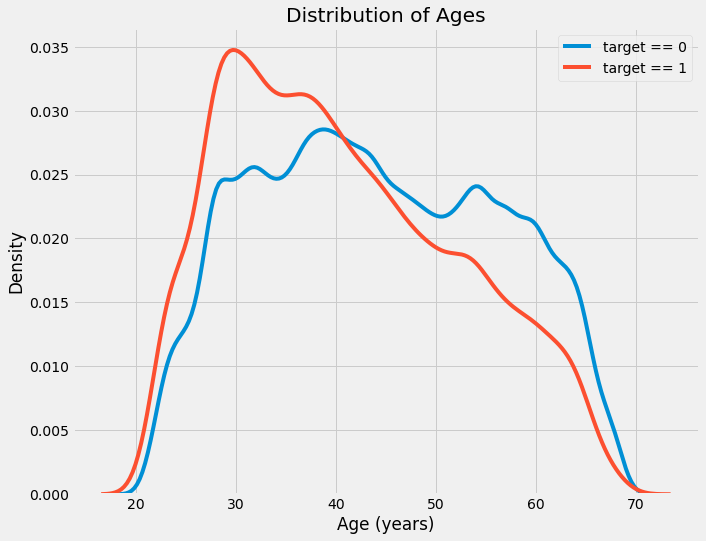

In [32]:
# Set the style of plots
plt.style.use('fivethirtyeight')

plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages'); plt.legend();

In [33]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [34]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


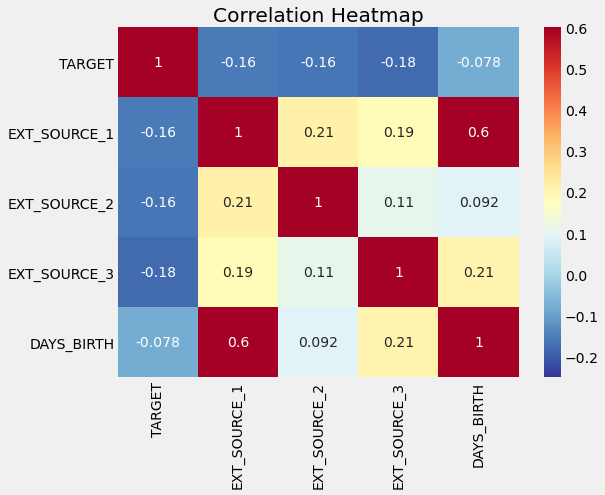

In [35]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [50]:
app_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100001,0,0,1,0,135000.0,568800.0,20560.5,450000.0,0.018850,...,0,0,0,0,0,1,0,1,0,False
1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,0.035792,...,0,0,0,0,0,0,0,0,0,False
2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,0.019101,...,0,0,0,0,0,0,0,0,0,False
3,100028,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,...,0,0,0,0,1,0,0,1,0,False
4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,0.010032,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,0,1,0,121500.0,412560.0,17473.5,270000.0,0.002042,...,0,0,0,0,0,0,0,0,0,False
48740,456222,0,0,0,2,157500.0,622413.0,31909.5,495000.0,0.035792,...,0,0,0,0,0,0,0,0,0,False
48741,456223,0,1,1,1,202500.0,315000.0,33205.5,315000.0,0.026392,...,0,0,0,0,0,1,0,1,0,False
48742,456224,0,0,0,0,225000.0,450000.0,25128.0,450000.0,0.018850,...,0,0,0,0,1,0,0,1,0,False


In [51]:
app_train.shape

(307511, 241)

In [52]:
app_test.shape

(48744, 240)

### Feature Engineering (Domain Knowledge Features)

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar:
* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [165]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [166]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

### Imputer, MinMaxScaler

In [56]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


### LogisticRegression

In [140]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 1, class_weight=None)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=1)

In [141]:
log_reg_pred_train = log_reg.predict_proba(train)[:, 1]
log_reg_pred_train[:20]

array([0.61110921, 0.02792273, 0.03435038, 0.06856241, 0.08453007,
       0.10431794, 0.00509334, 0.03625197, 0.05559868, 0.03243256,
       0.0664343 , 0.02429028, 0.10093611, 0.04199686, 0.03255696,
       0.14291927, 0.45351176, 0.04239663, 0.02386424, 0.04178679])

In [142]:
log_reg.predict(train)[10000:10020]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [143]:
train_labels[10000:10020]

10000    0
10001    0
10002    0
10003    0
10004    0
10005    0
10006    1
10007    0
10008    0
10009    1
10010    0
10011    0
10012    0
10013    1
10014    0
10015    0
10016    0
10017    0
10018    0
10019    1
Name: TARGET, dtype: int64

In [144]:
log_reg.predict(train).sum()

547

In [145]:
train_labels.sum()

24825

In [146]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_labels, log_reg_pred_train)

0.7470457305480281

In [147]:
log_reg.score(train, train_labels)

0.9192158979678776

In [148]:
log_reg.decision_function(train)

array([ 0.45197713, -3.54999429, -3.33618786, ..., -2.86723055,
       -2.91671178, -2.43465199])

#### Prédictions sur test set

In [149]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]
log_reg_pred

array([0.05479213, 0.2151662 , 0.03996552, ..., 0.05788938, 0.05258301,
       0.12861885])

In [150]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred
display(submit.head())

,SK_ID_CURR,TARGET
0,100001,0.054792
1,100005,0.215166
2,100013,0.039966
3,100028,0.038929
4,100038,0.125670


In [151]:
# Save the submission to a csv file
submit.to_csv('submission.csv', index = False)

In [139]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Logistic Regression ; identique code willkoehrsen"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.29M [00:00<?, ?B/s]
  1%|          | 8.00k/1.29M [00:00<00:18, 71.8kB/s]
 48%|####7     | 632k/1.29M [00:00<00:00, 3.56MB/s] 
100%|##########| 1.29M/1.29M [00:03<00:00, 383kB/s]


|Private Score|Public Score|
|-|-|
|0.68439 |0.67887|

In [139]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Logistic Regression"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.29M [00:00<?, ?B/s]
  1%|          | 8.00k/1.29M [00:00<00:18, 71.8kB/s]
 48%|####7     | 632k/1.29M [00:00<00:00, 3.56MB/s] 
100%|##########| 1.29M/1.29M [00:03<00:00, 383kB/s]


|Private Score|Public Score|
|-|-|
|0.73155|0.73607|

La seule modif que j'ai faite est de passer C = 0.0001 (bcp trop régularisé) à C=1 (défaut).

### Random Forest

In [152]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

#### Testing features from df_application

In [153]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [156]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions
display(submit.head())

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

,SK_ID_CURR,TARGET
0,100001,0.13
1,100005,0.21
2,100013,0.05
3,100028,0.14
4,100038,0.20


In [155]:
!kaggle competitions submit -c home-credit-default-risk -f random_forest_baseline.csv -m "Random Forest v0"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/614k [00:00<?, ?B/s]
  1%|1         | 8.00k/614k [00:00<00:07, 81.2kB/s]
 74%|#######4  | 456k/614k [00:00<00:00, 2.69MB/s] 
100%|##########| 614k/614k [00:04<00:00, 136kB/s] 


|Private Score|Public Score|
|-|-|
|0.68009|0.67877|

Aucune modif faite.

#### Testing Domain Features

In [167]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = SimpleImputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [168]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

In [169]:
!kaggle competitions submit -c home-credit-default-risk -f random_forest_baseline_domain.csv -m "Random Forest domain v0"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/614k [00:00<?, ?B/s]
  1%|1         | 8.00k/614k [00:00<00:07, 78.6kB/s]
 98%|#########7| 600k/614k [00:00<00:00, 3.51MB/s] 
100%|##########| 614k/614k [00:04<00:00, 140kB/s] 


|Private Score|Public Score|
|-|-|
|0.68514|0.67996|

Aucune modif faite.

#### Feature Importances

In [159]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title(f'Feature Importances (total of {len(df)} features)')
    plt.show()
    
    return df

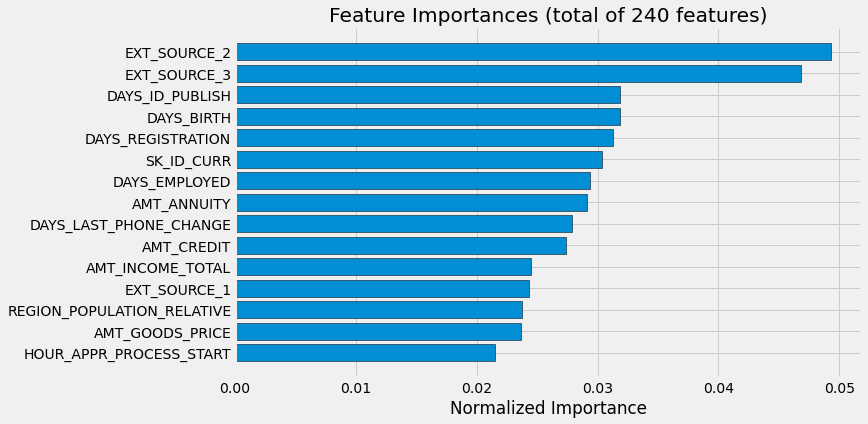

In [160]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

### Light Gradient Boosting Machine

In [216]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], 
                  categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

#### Testing features from df_application

In [171]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 239)
Testing Data Shape:  (48744, 239)
[200]	train's auc: 0.798723	train's binary_logloss: 0.547797	valid's auc: 0.755039	valid's binary_logloss: 0.563266
[400]	train's auc: 0.82838	train's binary_logloss: 0.518334	valid's auc: 0.755107	valid's binary_logloss: 0.545575
[200]	train's auc: 0.798409	train's binary_logloss: 0.548179	valid's auc: 0.758332	valid's binary_logloss: 0.563587
[400]	train's auc: 0.828244	train's binary_logloss: 0.518308	valid's auc: 0.758563	valid's binary_logloss: 0.545588
[200]	train's auc: 0.797648	train's binary_logloss: 0.549331	valid's auc: 0.763246	valid's binary_logloss: 0.564236
[200]	train's auc: 0.798855	train's binary_logloss: 0.547952	valid's auc: 0.757131	valid's binary_logloss: 0.562234
[200]	train's auc: 0.797918	train's binary_logloss: 0.548584	valid's auc: 0.758065	valid's binary_logloss: 0.564721
Baseline metrics
      fold     train     valid
0        0  0.816657  0.755215
1        1  0.816900  0.758754
2        

In [173]:
submission.to_csv('baseline_lgb.csv', index = False)

In [174]:
!kaggle competitions submit -c home-credit-default-risk -f baseline_lgb.csv -m "baseline_lgb v0"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.27M [00:00<?, ?B/s]
 17%|#6        | 216k/1.27M [00:00<00:00, 2.18MB/s]
 67%|######7   | 880k/1.27M [00:00<00:00, 4.85MB/s]
100%|##########| 1.27M/1.27M [00:03<00:00, 377kB/s]


|Private Score|Public Score|
|-|-|
|0.73830|0.73469|

Aucune modif faite.

#### Testing Domain Features

In [175]:
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

Training Data Shape:  (307511, 243)
Testing Data Shape:  (48744, 243)
[200]	train's auc: 0.804779	train's binary_logloss: 0.541283	valid's auc: 0.762511	valid's binary_logloss: 0.557227
[200]	train's auc: 0.804016	train's binary_logloss: 0.542318	valid's auc: 0.765768	valid's binary_logloss: 0.557819
[200]	train's auc: 0.8038	train's binary_logloss: 0.542856	valid's auc: 0.7703	valid's binary_logloss: 0.557925
[400]	train's auc: 0.834559	train's binary_logloss: 0.511454	valid's auc: 0.770511	valid's binary_logloss: 0.538558
[200]	train's auc: 0.804603	train's binary_logloss: 0.541718	valid's auc: 0.765497	valid's binary_logloss: 0.556274
[200]	train's auc: 0.804782	train's binary_logloss: 0.541397	valid's auc: 0.765076	valid's binary_logloss: 0.558641
Baseline with domain knowledge features metrics
      fold     train     valid
0        0  0.815523  0.763069
1        1  0.807075  0.766062
2        2  0.832138  0.770730
3        3  0.811100  0.765884
4        4  0.819404  0.765249
5  o

In [176]:
submission_domain.to_csv('baseline_lgb_domain_features.csv', index = False)

In [177]:
!kaggle competitions submit -c home-credit-default-risk -f baseline_lgb_domain_features.csv -m "baseline_lgb_domain_features v0"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.27M [00:00<?, ?B/s]
  1%|          | 8.00k/1.27M [00:00<00:18, 72.4kB/s]
 35%|###4      | 456k/1.27M [00:00<00:00, 2.58MB/s] 
100%|##########| 1.27M/1.27M [00:04<00:00, 317kB/s]


|Private Score|Public Score|
|-|-|
|0.75283|0.75440|

Aucune modif faite.

## Kernel 2 : Manual Feature Engineering - part 1

https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
    
Dans le premier kernel, l'auteur n'utilisait que les variables issues des fichiers application.csv. Il a ajouté 4 variables issu d'un feature engineering (domain knowledge).  
Dans ce second kernel, l'auteur inclut des variables créées à partir des autres fichiers .csv.  
Résultat : pas d'amélioration de l'AUC-ROC.

## Kernel 3 : Manual Feature Engineering - part 2

# Kernel de Aguiar

https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

Points forts de ce kernel :  
- nombreuses features issues d'un feature engineering à partir de tous les fichiers .csv  
- modélisation avec un classifieur LightGBM  

Points faibles :
- pas d'optimisation du classifieur ; les valeurs des paramètres sont prises d'un autre auteur de kernel.  
- utilisation de one-hot-encoding (non pertinent pour LGBM).  
- pas d'imputation des valeurs manquantes.  
- pas de correction des imbalances des datasets.

In [9]:
# Mode debug : calculs rapides sur un nb limité de lignes (120s pour feature engineering si debug=False)
debug = False
num_rows_debug = 2000

## Feature engineering

In [10]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()  # les lignes de test_df sont concaténées après les lignes du dataset train
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

# Retourne le nb de colonnes d'un dataframe
def nb_colonnes(df):
    cprint(f"Nb de colonnes du dataframe global: {len(df.columns)}", attrs=['bold'])

with timer("Full feature engineering run"):
    num_rows = num_rows_debug if debug else None
    df = application_train_test(num_rows)
    nb_colonnes(df)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    nb_colonnes(df)
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    nb_colonnes(df)
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    nb_colonnes(df)
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    nb_colonnes(df)
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    nb_colonnes(df)

Train samples: 307511, test samples: 48744
Nb de colonnes du dataframe global: 248
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 21s
Nb de colonnes du dataframe global: 364
Previous applications df shape: (338857, 249)
Process previous_applications - done in 28s
Nb de colonnes du dataframe global: 613
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 14s
Nb de colonnes du dataframe global: 631
Installments payments df shape: (339587, 26)
Process installments payments - done in 32s
Nb de colonnes du dataframe global: 657
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 22s
Nb de colonnes du dataframe global: 798
Full feature engineering run - done in 123s


In [11]:
for col in df.columns:
    print(col, end='    ')

index    SK_ID_CURR    TARGET    CODE_GENDER    FLAG_OWN_CAR    FLAG_OWN_REALTY    CNT_CHILDREN    AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY    AMT_GOODS_PRICE    REGION_POPULATION_RELATIVE    DAYS_BIRTH    DAYS_EMPLOYED    DAYS_REGISTRATION    DAYS_ID_PUBLISH    OWN_CAR_AGE    FLAG_MOBIL    FLAG_EMP_PHONE    FLAG_WORK_PHONE    FLAG_CONT_MOBILE    FLAG_PHONE    FLAG_EMAIL    CNT_FAM_MEMBERS    REGION_RATING_CLIENT    REGION_RATING_CLIENT_W_CITY    HOUR_APPR_PROCESS_START    REG_REGION_NOT_LIVE_REGION    REG_REGION_NOT_WORK_REGION    LIVE_REGION_NOT_WORK_REGION    REG_CITY_NOT_LIVE_CITY    REG_CITY_NOT_WORK_CITY    LIVE_CITY_NOT_WORK_CITY    EXT_SOURCE_1    EXT_SOURCE_2    EXT_SOURCE_3    APARTMENTS_AVG    BASEMENTAREA_AVG    YEARS_BEGINEXPLUATATION_AVG    YEARS_BUILD_AVG    COMMONAREA_AVG    ELEVATORS_AVG    ENTRANCES_AVG    FLOORSMAX_AVG    FLOORSMIN_AVG    LANDAREA_AVG    LIVINGAPARTMENTS_AVG    LIVINGAREA_AVG    NONLIVINGAPARTMENTS_AVG    NONLIVINGAREA_AVG    APARTMENTS_MODE    

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356251 entries, 0 to 356254
Columns: 798 entries, index to CC_COUNT
dtypes: float64(622), int64(43), uint8(133)
memory usage: 1.8 GB


In [176]:
df.describe()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,...,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_D

Du fait du one-hot encoding dans le kernel d'Aguiar, toutes les variables sont quantitatives.  
Une standardisation n'est pas nécessaire si on travaille avec des arbres de décision.

## Train test split

### Préparation de X_train, y_train, X_test (à partir de df)

In [12]:
# pour éviter l'erreur : "LightGBMError: Do not support special JSON characters in feature name"
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Divide in training/validation and test data    
df_train = df[df['TARGET'].notnull()]
df_test = df[df['TARGET'].isnull()]

feats = [f for f in df_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

X_train, y_train = df_train[feats], df_train['TARGET']
X_test           = df_test[feats]

print("X_train shape: {}, test shape: {}".format(X_train.shape, X_test.shape))

X_train shape: (307507, 795), test shape: (48744, 795)


### Partition de df_train en X_split_train, X_split_valid, y_split_train, y_split_valid

In [13]:
# split avec stratification
df_split_train, df_split_valid = train_test_split(df_train, test_size=0.1, stratify=df_train['TARGET'], random_state=0)

# séparation entre les variables prédictives (X) et à prédire (y)
X_split_train, X_split_valid = df_split_train[feats], df_split_valid[feats]
y_split_train, y_split_valid = df_split_train['TARGET'], df_split_valid['TARGET']
print("X_split_train shape: {}, X_split_valid shape: {}".format(X_split_train.shape, X_split_valid.shape))
print("y_split_train shape: {}, y_split_valid shape: {}".format(y_split_train.shape, y_split_valid.shape))

del df_split_train, df_split_valid

X_split_train shape: (276756, 795), X_split_valid shape: (30751, 795)
y_split_train shape: (276756,), y_split_valid shape: (30751,)


## Dummy classifiers

###### Stratégie "most_frequent"

In [14]:
dclf = DummyClassifier(strategy="most_frequent")
dclf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [15]:
y_test_pred_proba = dclf.predict_proba(X_test)
print(y_test_pred_proba)
print("somme :", y_test_pred_proba.sum())

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
somme : 48744.0


In [127]:
# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_test_pred_proba[:,1]})
submission.to_csv('dclf_most_frequent_full_features.csv', index = False)

In [128]:
!kaggle competitions submit -c home-credit-default-risk -f dclf_most_frequent_full_features.csv -m "dclf_most_frequent_full_features v1"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/571k [00:00<?, ?B/s]
 34%|###3      | 192k/571k [00:00<00:00, 1.93MB/s]
100%|##########| 571k/571k [00:03<00:00, 154kB/s] 


|Private Score|Public Score|
|-|-|
|0.50293|0.49871|

In [16]:
y_train_pred_proba = dclf.predict_proba(X_train)
fpr, tpr, thr = roc_curve(y_train, y_train_pred_proba[:,1])

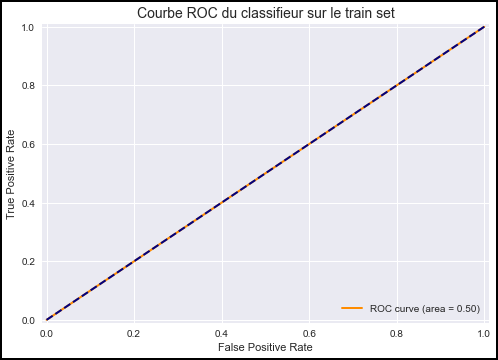

In [17]:
plt.figure(edgecolor='black', linewidth=4)
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC du classifieur sur le train set", fontsize=14)
plt.legend(loc="lower right")
plt.show()

###### Stratégie "stratified"

In [118]:
dclf = DummyClassifier(strategy="stratified")
dclf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [147]:
y_test_pred_proba = dclf.predict_proba(X_test)
print(y_test_pred_proba)
print("somme :", y_test_pred_proba.sum())

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
somme : 48744.0


In [122]:
# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_test_pred_proba[:,1]})
submission.to_csv('dclf_stratified_full_features.csv', index = False)

In [124]:
!kaggle competitions submit -c home-credit-default-risk -f dclf_stratified_full_features.csv -m "dclf_stratified_full_features v1"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/571k [00:00<?, ?B/s]
  1%|1         | 8.00k/571k [00:00<00:07, 75.1kB/s]
100%|##########| 571k/571k [00:03<00:00, 162kB/s]  


|Private Score|Public Score|
|-|-|
|0.50293|0.49871|

###### Stratégie "prior"

In [208]:
dclf = DummyClassifier(strategy="prior")
dclf.fit(X_train, y_train)

DummyClassifier()

In [209]:
y_test_pred_proba = dclf.predict_proba(X_test)
print(y_test_pred_proba)
print("somme :", y_test_pred_proba.sum())

[[0.91927013 0.08072987]
 [0.91927013 0.08072987]
 [0.91927013 0.08072987]
 ...
 [0.91927013 0.08072987]
 [0.91927013 0.08072987]
 [0.91927013 0.08072987]]
somme : 48744.00000000001


In [159]:
# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_test_pred_proba[:,1]})
submission.to_csv('dclf_prior_full_features.csv', index = False)

In [160]:
!kaggle competitions submit -c home-credit-default-risk -f dclf_prior_full_features.csv -m "dclf_prior_full_features v1"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.30M [00:00<?, ?B/s]
  6%|6         | 80.0k/1.30M [00:00<00:01, 787kB/s]
 48%|####8     | 640k/1.30M [00:00<00:00, 3.63MB/s]
100%|##########| 1.30M/1.30M [00:03<00:00, 395kB/s]


|Private Score|Public Score|
|-|-|
|0.50000|0.50000|

In [210]:
y_train_pred_proba = dclf.predict_proba(X_train)
fpr, tpr, thr = roc_curve(y_train, y_train_pred_proba[:,1])

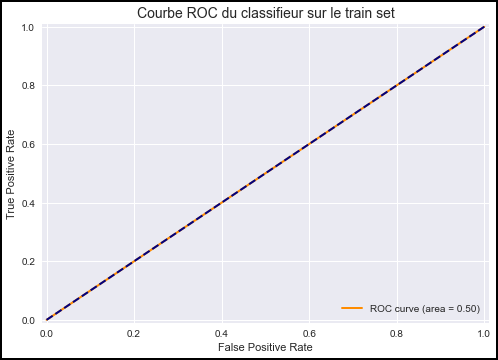

In [211]:
plt.figure(edgecolor='black', linewidth=4)
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC du classifieur sur le train set", fontsize=14)
plt.legend(loc="lower right")
plt.show()

###### Stratégie "uniform"

In [164]:
dclf = DummyClassifier(strategy="uniform")
dclf.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [165]:
y_test_pred_proba = dclf.predict_proba(X_test)
print(y_test_pred_proba)
print("somme :", y_test_pred_proba.sum())

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 ...
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
somme : 48744.0


In [166]:
# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_test_pred_proba[:,1]})
submission.to_csv('dclf_uniform_full_features.csv', index = False)

In [167]:
!kaggle competitions submit -c home-credit-default-risk -f dclf_uniform_full_features.csv -m "dclf_uniform_full_features v1"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/571k [00:00<?, ?B/s]
 18%|#8        | 104k/571k [00:00<00:00, 1.06MB/s]
100%|##########| 571k/571k [00:00<00:00, 3.23MB/s]
100%|##########| 571k/571k [00:01<00:00, 294kB/s] 


|Private Score|Public Score|
|-|-|
|0.50000|0.50000|

###### Stratégie "tirage aléatoire (distribution uniforme) du predict_proba entre 0 et 1"

In [212]:
y_test_pred_proba = np.random.random(48744)
print(y_test_pred_proba)
print("somme :", y_test_pred_proba.sum())

[0.29711287 0.73968418 0.4554519  ... 0.13893572 0.08266807 0.79173035]
somme : 24472.3425109017


In [213]:
48744/2

24372.0

In [176]:
# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_test_pred_proba})
submission.to_csv('dclf_tirage_aleatoire_full_features.csv', index = False)

In [177]:
!kaggle competitions submit -c home-credit-default-risk -f dclf_tirage_aleatoire_full_features.csv -m "dclf_tirage_aleatoire_full_features v1"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.27M [00:00<?, ?B/s]
  8%|8         | 104k/1.27M [00:00<00:01, 1.02MB/s]
 57%|#####6    | 736k/1.27M [00:00<00:00, 4.13MB/s]
100%|##########| 1.27M/1.27M [00:04<00:00, 293kB/s]


|Private Score|Public Score|
|-|-|
|0.50447|0.49823|

In [214]:
y_train_pred_proba = dclf.predict_proba(X_train)
fpr, tpr, thr = roc_curve(y_train, y_train_pred_proba[:,1])

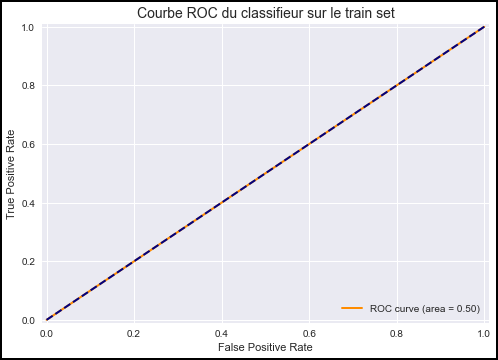

In [215]:
plt.figure(edgecolor='black', linewidth=4)
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC du classifieur sur le train set", fontsize=14)
plt.legend(loc="lower right")
plt.show()

## Classification avec LightGBM

### Code d'Aguiar avec qques modifs

In [29]:
# num_folds = 10
# stratified = True

# # LightGBM GBDT with KFold or Stratified KFold
# # Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

# # pour éviter l'erreur : "LightGBMError: Do not support special JSON characters in feature name"
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# # Divide in training/validation and test data    
# train_df = df[df['TARGET'].notnull()]
# test_df = df[df['TARGET'].isnull()]
# print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

# # Cross validation model
# if stratified:
#     folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
# else:
#     folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)

# # Create arrays and dataframes to store results
# oof_preds = np.zeros(train_df.shape[0])
# sub_preds = np.zeros(test_df.shape[0])
# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#     train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
#     valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

#     # LightGBM instanciation
#     clf = LGBMClassifier()

#     clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#         eval_metric= 'auc', verbose=20)

#     oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
#     sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = feats
#     fold_importance_df["importance"] = clf.feature_importances_
#     fold_importance_df["fold"] = n_fold + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
#     del clf

# print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

# # Write submission file and plot feature importance
# bool_submission = False
# if bool_submission:
#     test_df['TARGET'] = sub_preds
#     test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
# # display_importances(feature_importance_df)


Starting LightGBM. Train shape: (2000, 730), test shape: (2000, 730)
[20]	training's auc: 0.999443	training's binary_logloss: 0.077107	valid_1's auc: 0.71964	valid_1's binary_logloss: 0.260234


C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	training's auc: 1	training's binary_logloss: 0.0284168	valid_1's auc: 0.692613	valid_1's binary_logloss: 0.305643
[60]	training's auc: 1	training's binary_logloss: 0.0114928	valid_1's auc: 0.727928	valid_1's binary_logloss: 0.335504
[80]	training's auc: 1	training's binary_logloss: 0.00487165	valid_1's auc: 0.708468	valid_1's binary_logloss: 0.389337
[100]	training's auc: 1	training's binary_logloss: 0.0020994	valid_1's auc: 0.722523	valid_1's binary_logloss: 0.432604
Fold  1 AUC : 0.722523


C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's auc: 0.999724	training's binary_logloss: 0.0799289	valid_1's auc: 0.73009	valid_1's binary_logloss: 0.246574
[40]	training's auc: 1	training's binary_logloss: 0.0311239	valid_1's auc: 0.723964	valid_1's binary_logloss: 0.266656
[60]	training's auc: 1	training's binary_logloss: 0.0128064	valid_1's auc: 0.741622	valid_1's binary_logloss: 0.296995
[80]	training's auc: 1	training's binary_logloss: 0.00553154	valid_1's auc: 0.77045	valid_1's binary_logloss: 0.326068
[100]	training's auc: 1	training's binary_logloss: 0.00240732	valid_1's auc: 0.774054	valid_1's binary_logloss: 0.371624
Fold  2 AUC : 0.774054


C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's auc: 0.999526	training's binary_logloss: 0.0801471	valid_1's auc: 0.647568	valid_1's binary_logloss: 0.273026
[40]	training's auc: 1	training's binary_logloss: 0.0311488	valid_1's auc: 0.627027	valid_1's binary_logloss: 0.319312
[60]	training's auc: 1	training's binary_logloss: 0.0127505	valid_1's auc: 0.641802	valid_1's binary_logloss: 0.363811
[80]	training's auc: 1	training's binary_logloss: 0.00534399	valid_1's auc: 0.667387	valid_1's binary_logloss: 0.401827
[100]	training's auc: 1	training's binary_logloss: 0.00231126	valid_1's auc: 0.682162	valid_1's binary_logloss: 0.44015
Fold  3 AUC : 0.682162


C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's auc: 0.999249	training's binary_logloss: 0.0789803	valid_1's auc: 0.71964	valid_1's binary_logloss: 0.249697
[40]	training's auc: 1	training's binary_logloss: 0.0298805	valid_1's auc: 0.69009	valid_1's binary_logloss: 0.284165
[60]	training's auc: 1	training's binary_logloss: 0.0124807	valid_1's auc: 0.683604	valid_1's binary_logloss: 0.323433
[80]	training's auc: 1	training's binary_logloss: 0.00538232	valid_1's auc: 0.691892	valid_1's binary_logloss: 0.359166
[100]	training's auc: 1	training's binary_logloss: 0.00231005	valid_1's auc: 0.692973	valid_1's binary_logloss: 0.403393
Fold  4 AUC : 0.692973


C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's auc: 0.999125	training's binary_logloss: 0.0801288	valid_1's auc: 0.769009	valid_1's binary_logloss: 0.236397
[40]	training's auc: 1	training's binary_logloss: 0.0314052	valid_1's auc: 0.803964	valid_1's binary_logloss: 0.247016
[60]	training's auc: 1	training's binary_logloss: 0.0130369	valid_1's auc: 0.800721	valid_1's binary_logloss: 0.272249
[80]	training's auc: 1	training's binary_logloss: 0.00559773	valid_1's auc: 0.803964	valid_1's binary_logloss: 0.299721
[100]	training's auc: 1	training's binary_logloss: 0.00241073	valid_1's auc: 0.798559	valid_1's binary_logloss: 0.330114
Fold  5 AUC : 0.798559


C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's auc: 0.999538	training's binary_logloss: 0.0787533	valid_1's auc: 0.736175	valid_1's binary_logloss: 0.24065
[40]	training's auc: 1	training's binary_logloss: 0.0304255	valid_1's auc: 0.667435	valid_1's binary_logloss: 0.275227
[60]	training's auc: 1	training's binary_logloss: 0.0125597	valid_1's auc: 0.662058	valid_1's binary_logloss: 0.316331
[80]	training's auc: 1	training's binary_logloss: 0.00533341	valid_1's auc: 0.670507	valid_1's binary_logloss: 0.355763
[100]	training's auc: 1	training's binary_logloss: 0.00238021	valid_1's auc: 0.664747	valid_1's binary_logloss: 0.39675
Fold  6 AUC : 0.664747


C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's auc: 0.999026	training's binary_logloss: 0.078468	valid_1's auc: 0.749616	valid_1's binary_logloss: 0.243198
[40]	training's auc: 1	training's binary_logloss: 0.0300745	valid_1's auc: 0.720046	valid_1's binary_logloss: 0.272237
[60]	training's auc: 1	training's binary_logloss: 0.01255	valid_1's auc: 0.733103	valid_1's binary_logloss: 0.292335
[80]	training's auc: 1	training's binary_logloss: 0.00525728	valid_1's auc: 0.726959	valid_1's binary_logloss: 0.329717
[100]	training's auc: 1	training's binary_logloss: 0.00225365	valid_1's auc: 0.72427	valid_1's binary_logloss: 0.372216
Fold  7 AUC : 0.724270


C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's auc: 0.99844	training's binary_logloss: 0.0806757	valid_1's auc: 0.827189	valid_1's binary_logloss: 0.217169
[40]	training's auc: 1	training's binary_logloss: 0.0311949	valid_1's auc: 0.803379	valid_1's binary_logloss: 0.237211
[60]	training's auc: 1	training's binary_logloss: 0.0129021	valid_1's auc: 0.812596	valid_1's binary_logloss: 0.263267
[80]	training's auc: 1	training's binary_logloss: 0.00542541	valid_1's auc: 0.799923	valid_1's binary_logloss: 0.298692
[100]	training's auc: 1	training's binary_logloss: 0.00235098	valid_1's auc: 0.78149	valid_1's binary_logloss: 0.338285
Fold  8 AUC : 0.781490


C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's auc: 0.999808	training's binary_logloss: 0.0795924	valid_1's auc: 0.721582	valid_1's binary_logloss: 0.23879
[40]	training's auc: 1	training's binary_logloss: 0.0312084	valid_1's auc: 0.718126	valid_1's binary_logloss: 0.261492
[60]	training's auc: 1	training's binary_logloss: 0.013299	valid_1's auc: 0.713134	valid_1's binary_logloss: 0.307126
[80]	training's auc: 1	training's binary_logloss: 0.00574972	valid_1's auc: 0.710829	valid_1's binary_logloss: 0.346786
[100]	training's auc: 1	training's binary_logloss: 0.00253087	valid_1's auc: 0.702765	valid_1's binary_logloss: 0.394492
Fold  9 AUC : 0.702765


C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's auc: 0.99866	training's binary_logloss: 0.0819697	valid_1's auc: 0.78725	valid_1's binary_logloss: 0.221855
[40]	training's auc: 1	training's binary_logloss: 0.0320437	valid_1's auc: 0.768817	valid_1's binary_logloss: 0.247909
[60]	training's auc: 1	training's binary_logloss: 0.0134685	valid_1's auc: 0.744624	valid_1's binary_logloss: 0.288693
[80]	training's auc: 1	training's binary_logloss: 0.00568497	valid_1's auc: 0.731183	valid_1's binary_logloss: 0.31938
[100]	training's auc: 1	training's binary_logloss: 0.0024403	valid_1's auc: 0.747696	valid_1's binary_logloss: 0.350334
Fold 10 AUC : 0.747696
Full AUC score 0.726874


### Remise à plat du code de Aguiar

#### Prise en main du GridSearchCV sur LGBM (à 1 dimension)

###### Entrainement sur X_train

In [20]:
param_grid = [{'num_iterations': [50, 100]}, {'num_leaves': [15, 31]}]

clf = LGBMClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)

# grid_search.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose=-1)
grid_search.fit(X_train, y_train, eval_metric= 'auc', verbose=-1)

C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid=[{'num_iterations': [50, 100]},
                         {'num_leaves': [15, 31]}],
             return_train_score=True, scoring='roc_auc')

In [21]:
affichage_scores(grid_search)

roc_auc = 0.776    {'num_iterations': 50}
roc_auc = 0.783    {'num_iterations': 100}
roc_auc = 0.781    {'num_leaves': 15}
roc_auc = 0.783    {'num_leaves': 31}
Best roc_auc = 0.783    {'num_iterations': 100}


#### Prise en main du GridSearchCV sur LGBM (à plusieurs dimensions)

In [97]:
param_grid = [{'num_iterations': [50, 100], 'num_leaves': [15, 31]}]

clf = LGBMClassifier()

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)

# grid_search.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose=-1)
grid_search.fit(X_train, y_train, eval_metric= 'auc', verbose=-1)

C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid=[{'num_iterations': [50, 100], 'num_leaves': [15, 31]}],
             return_train_score=True, scoring='roc_auc')

In [98]:
affichage_scores(grid_search, tri=True)

roc_auc = 0.759    {'num_iterations': 100, 'num_leaves': 15}
roc_auc = 0.753    {'num_iterations': 50, 'num_leaves': 15}
roc_auc = 0.749    {'num_iterations': 100, 'num_leaves': 31}
roc_auc = 0.742    {'num_iterations': 50, 'num_leaves': 31}


#### Prédiction sur test set et soummissions à Kaggle (sans GridSearch)

##### Entrainement sur X_train

In [ ]:
clf = LGBMClassifier()
clf.fit(X_train, y_train, eval_metric= 'auc', verbose=-1)

In [179]:
clf.predict(X_test).sum()

169.0

In [108]:
y_test_pred = clf.predict_proba(X_test)

In [109]:
y_test_pred[:,1]

array([0.04006977, 0.18289602, 0.03272484, ..., 0.01196195, 0.04091878, 0.19603759])

In [110]:
df_test['SK_ID_CURR']

307511    100001
307512    100005
307513    100013
307514    100028
307515    100038
           ...  
356250    456221
356251    456222
356252    456223
356253    456224
356254    456250
Name: SK_ID_CURR, Length: 48744, dtype: int64

In [112]:
y_test_pred.shape

(48744, 2)

In [113]:
# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_test_pred[:,1]})

In [114]:
submission.to_csv('lgbm_full_features.csv', index = False)

In [116]:
!kaggle competitions submit -c home-credit-default-risk -f lgbm_full_features.csv -m "lgbm full features v1"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.31M [00:00<?, ?B/s]
  6%|5         | 80.0k/1.31M [00:00<00:01, 772kB/s]
 51%|#####1    | 688k/1.31M [00:00<00:00, 3.87MB/s]
100%|##########| 1.31M/1.31M [00:03<00:00, 359kB/s]


|Private Score|Public Score|
|-|-|
|0.77976|0.78696|

Premier dépôt de LGBM entrainé avec les paramètres par défaut, avec les features de Aguiar.

##### Entrainement sur X_split_train

In [163]:
clf = LGBMClassifier()
clf.fit(X_split_train, y_split_train, eval_metric= 'auc', verbose=-1)

C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier()

In [164]:
clf.predict(X_test).sum()

158.0

In [38]:
y_test_pred_proba = clf.predict_proba(X_test)

# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_test_pred_proba[:,1]})

submission.to_csv('lgbm_full_features_v3.csv', index = False)

In [39]:
!kaggle competitions submit -c home-credit-default-risk -f lgbm_full_features_v3.csv -m "lgbm full features v3"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.31M [00:00<?, ?B/s]
 15%|#4        | 200k/1.31M [00:00<00:00, 2.03MB/s]
 48%|####8     | 648k/1.31M [00:00<00:00, 3.47MB/s]
100%|##########| 1.31M/1.31M [00:04<00:00, 282kB/s]


Dépôt v3 de LGBM entrainé avec les paramètres par défaut, avec les features de Aguiar, sur uniquement X_split_train.  

|Objet|Private Score|Public Score|Note|
|-|-|-|-|
|v1 (training avec X_train)|0.77976|0.78696|Score de 0.8263 sur X_train|
|v3 (training avec X_split_train)|0.77858|0.78217|Score de 0.7909 sur X_split_valid , 0.8303 sur X_split_train|

##### Courbe ROC du train set

,Predicted 0,Predicted 1
Actual 0,28188,80
Actual 1,2401,82


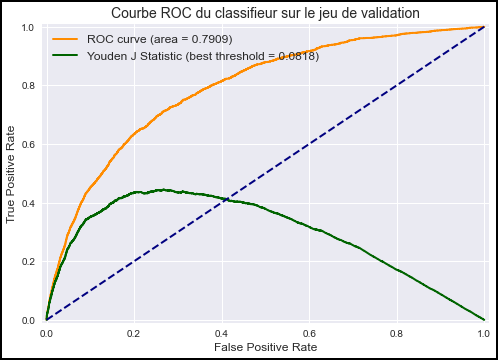

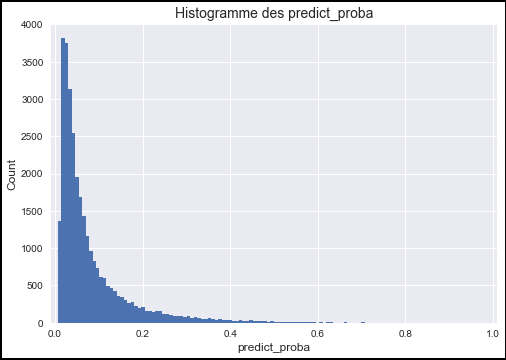

In [174]:
metriques_classif_binaire(clf, X_split_valid, y_split_valid)

### Gestion de l'imbalanced data

Class 0: 282682
Class 1: 24825
Proportion: 11.39 : 1


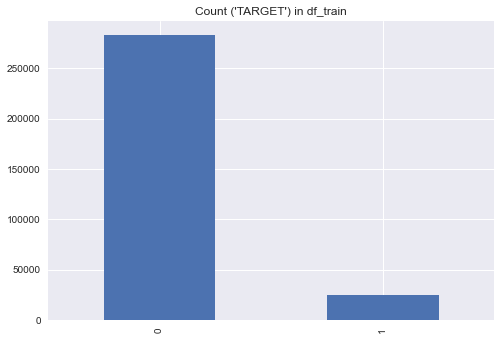

In [114]:
target_count = df_train.TARGET.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title="Count ('TARGET') in df_train")
plt.xticks(ticks = [0, 1], labels=['0', '1']);

#### Random under-sampling

In [159]:
rus = imblearn.under_sampling.RandomUnderSampler(random_state=0, replacement=True)# fit predictor and target variable
X_split_train_rus, y_split_train_rus = rus.fit_resample(X_split_train, y_split_train)

print('Original dataset shape:', Counter(y_split_train))
print('Resample dataset shape', Counter(y_split_train_rus))

Original dataset shape: Counter({0.0: 254414, 1.0: 22342})
Resample dataset shape Counter({0.0: 22342, 1.0: 22342})


In [160]:
clf_rus = LGBMClassifier()
clf_rus.fit(X_split_train_rus, y_split_train_rus, eval_metric= 'auc', verbose=-1)

C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier()

In [161]:
clf_rus.predict(X_test).sum()

15148.0

,Predicted 0,Predicted 1
Actual 0,20023,8245
Actual 1,680,1803


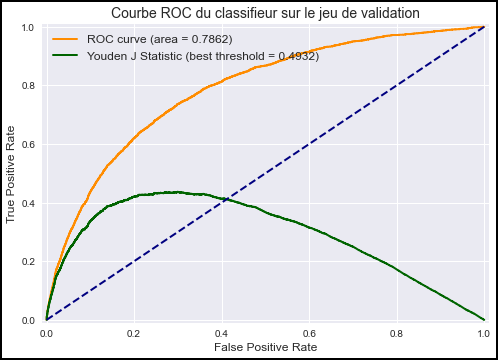

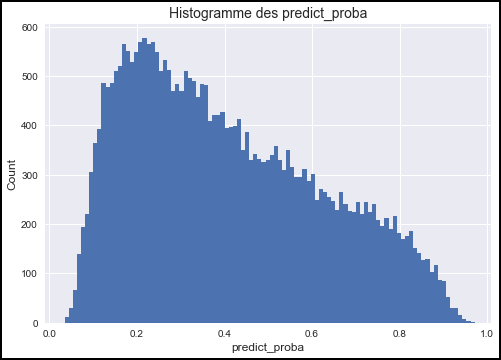

In [173]:
metriques_classif_binaire(clf_rus, X_split_valid, y_split_valid)

#### Random over-sampling

In [119]:
ros = imblearn.over_sampling.RandomOverSampler(random_state=0)
X_split_train_ros, y_split_train_ros = ros.fit_resample(X_split_train, y_split_train)

print('Original dataset shape:', Counter(y_split_train))
print('Resample dataset shape', Counter(y_split_train_ros))

Original dataset shape: Counter({0.0: 254414, 1.0: 22342})
Resample dataset shape Counter({0.0: 254414, 1.0: 254414})


In [155]:
clf_ros = LGBMClassifier()
clf_ros.fit(X_split_train_ros, y_split_train_ros, eval_metric= 'auc', verbose=-1)

C:\Users\jmjoe\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier()

In [157]:
clf_ros.predict(X_test).sum()

13770.0

,Predicted 0,Predicted 1
Actual 0,20725,7543
Actual 1,725,1758


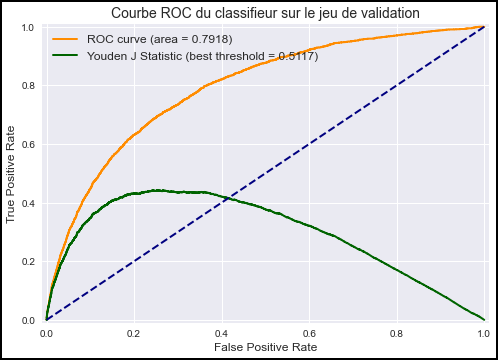

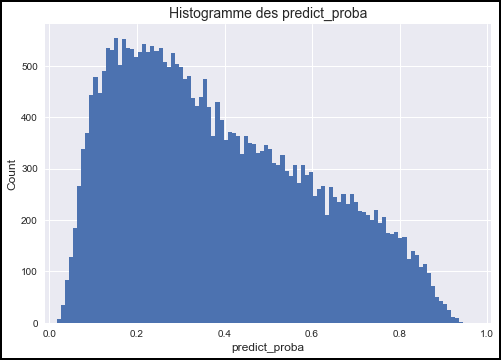

In [172]:
metriques_classif_binaire(clf_ros, X_split_valid, y_split_valid)

#### SMOTE

###### Etape préliminaire : se débarasser des colonnes contenant des NaN

In [199]:
X_split_train.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=795)

In [200]:
X_split_train.isnull().any()

CODE_GENDER                         False
FLAG_OWN_CAR                        False
FLAG_OWN_REALTY                     False
CNT_CHILDREN                        False
AMT_INCOME_TOTAL                    False
                                    ...  
CC_NAME_CONTRACT_STATUS_nan_MAX      True
CC_NAME_CONTRACT_STATUS_nan_MEAN     True
CC_NAME_CONTRACT_STATUS_nan_SUM      True
CC_NAME_CONTRACT_STATUS_nan_VAR      True
CC_COUNT                             True
Length: 795, dtype: bool

In [201]:
X_split_train.columns[X_split_train.isnull().any()]

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OWN_CAR_AGE',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=613)

# Feature engineering d'Aguiar totalement remis à plat